# Global Forecasting System - Meteorological forecast

In [1]:
from datetime import datetime
import xarray
import numpy as np
import pandas as pd
from mikeio import Dfs2

Let's try to download todays forecast from the OpenDAP server.

In [2]:
now = datetime.now()

forecast = datetime(now.year,now.month,now.day)

In [5]:
dtstr = forecast.strftime("%Y%m%d")
hour = "00" # valid options are 00,06,12,18
url = f"https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs{dtstr}/gfs_0p25_{hour}z"
ds = xarray.open_dataset(url)

In [6]:
ds.time.values[0],ds.time.values[-1]

(numpy.datetime64('2020-08-27T00:00:00.000000000'),
 numpy.datetime64('2020-09-06T00:00:00.000000000'))

In [7]:
(ds.time.values[-1]- ds.time.values[0]).astype('timedelta64[D]')

numpy.timedelta64(10,'D')

The forecast contains data for the coming 10 days.

Running a Mike 21 HD model, needs at least three variables of meteorlogical forcing
* Mean Sea Level Pressure
* U 10m
* V 10m

In [8]:
ds.msletmsl

<xarray.DataArray 'msletmsl' (time: 81, lat: 721, lon: 1440)>
[84097440 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-08-27 2020-08-27T03:00:00 ... 2020-09-06
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  ** mean sea level mslp (eta model reduction) [pa]

In [9]:
ds.ugrd10m

<xarray.DataArray 'ugrd10m' (time: 81, lat: 721, lon: 1440)>
[84097440 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-08-27 2020-08-27T03:00:00 ... 2020-09-06
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  ** 10 m above ground u-component of wind [m/s]

In [10]:
ds.vgrd10m

<xarray.DataArray 'vgrd10m' (time: 81, lat: 721, lon: 1440)>
[84097440 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-08-27 2020-08-27T03:00:00 ... 2020-09-06
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes:
    long_name:  ** 10 m above ground v-component of wind [m/s]

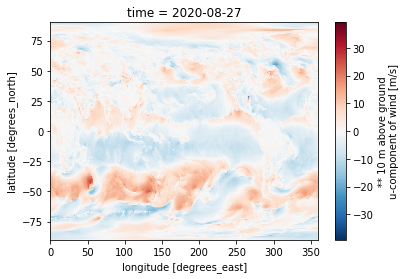

In [11]:
ds.ugrd10m[0].plot()

## Extract a sub-area for e.g. the Adriatic Sea

In [12]:
ds = ds.sel(lon=slice(10,25), lat=slice(30,50))

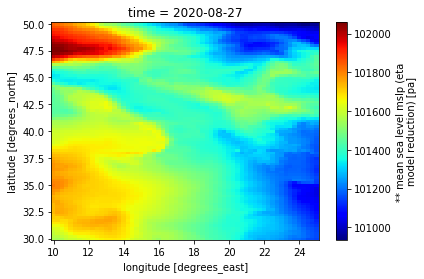

In [13]:
ds.msletmsl[0].plot(cmap='jet')

## Convert to dfs2

In [14]:
lat = ds.lat.values
lon = ds.lon.values

nx = len(lon)
ny = len(lat)

x0 = lon[0]
y0 = lat[0]

dx = np.round((lon[-1] - lon[0]) / nx,2)
dy = np.round((lat[-1] - lat[0]) / ny,2)

x0, y0, nx, ny, dx, dy

(10.0, 30.0, 61, 81, 0.25, 0.25)

## Time

In [15]:
t = ds.time.values
print(t[0])
start_time = pd.to_datetime(t).to_pydatetime()[0]

2020-08-27T00:00:00.000000000


## Variable types

In [16]:
from mikeio.eum import EUMType
EUMType.Air_Pressure

Air Pressure

In [17]:
EUMType.Air_Pressure.units

[hectopascal, millibar]

In [18]:
EUMType.Wind_Velocity

Wind Velocity

In [19]:
EUMType.Wind_Velocity.units

[meter per sec, feet per sec, miles per hour, km per hour, knot]

This example extracts the first 10 timesteps. Note that in order to download the entire forecast, you have to handle the non-equidistant time axis.

In [24]:
ds = ds.isel(time=slice(0,10))

mslp = ds.msletmsl.values / 100 # conversion from Pa to hPa
u = ds.ugrd10m.values
v = ds.vgrd10m.values

Flip data upside down

In [26]:
mslp = np.flip(mslp, axis=1)
u = np.flip(u, axis=1)
v = np.flip(v, axis=1)

In [27]:
from mikeio.eum import EUMUnit

EUMUnit.hectopascal

hectopascal

In [34]:
from mikeio.eum import ItemInfo, EUMUnit

d = [mslp, u, v]

dfsfilename = f"gfs_{dtstr}_{hour}.dfs2"

coordinate = ['LONG/LAT', x0, y0, 0]

items = [ItemInfo("Mean Sea Level Pressure", EUMType.Air_Pressure, EUMUnit.hectopascal),
        ItemInfo("Wind U", EUMType.Wind_Velocity, EUMUnit.meter_per_sec),
        ItemInfo("Wind V", EUMType.Wind_Velocity, EUMUnit.meter_per_sec)]

dfs = Dfs2()
dfs.write(filename=dfsfilename,
           data=d,
           start_time = start_time,
           dt=3600,
           items=items,
           coordinate=coordinate, dx=dx, dy=dy
)

![GFS in dfs2 format](../images/gfs.png)

## Clean up (don't run this)

In [35]:
import os
os.remove(dfsfilename)